<a href="https://colab.research.google.com/github/athanoid/eeg-mne-analysis/blob/master/eeg_preproc_mne.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [48]:
'''
EEG processing pipeline:

1. load data
2. load channels
3. bandpass
4. reref
5. epoch data
6. run ICA
7. reject artifacts
8. plot ERSP
'''
# Authors: Thanos <athanasios.vourvopoulos@tecnico.ulisboa.pt>
#
# License: BSD (3-clause)

print(__doc__)


EEG processing pipeline:

1. load data
2. load channels
3. bandpass
4. reref
5. epoch data
6. run ICA
7. reject artefacts
8. plot ERSP



In [49]:
# Import MNE library into Colab
try:
  import mne
  print('mne: {}'.format(mne.__version__))
except ModuleNotFoundError:
  !pip install mne --upgrade

mne: 0.20.0


In [50]:
# import data with $bash into /content

![ -f /content/ME-graz-block.gdf ] && echo "dataset exist" || wget 'https://my.laseeb.org/~thanos/bci/data/ME-graz-block.gdf'

![ -f /content/chanloc.loc ] && echo "chanloc exist" || wget 'https://my.laseeb.org/~thanos/bci/chanloc.loc'

dataset exist
chanloc exist


In [0]:
import numpy as np
import matplotlib.pyplot as plt
from time import time
import mne
from mne import Epochs, pick_types, events_from_annotations
from mne.channels import read_layout, read_custom_montage, find_layout, make_standard_montage, make_eeg_layout
from mne.io import concatenate_raws, read_raw_gdf, read_raw_eeglab
from mne.preprocessing import ICA


In [52]:
## 1. Load data
fileloc = 'ME-graz-block.gdf' # ME-graz-block.gdf , ME-graz-rand.gdf_proc.set

raw = read_raw_gdf(fileloc, stim_channel=-1, preload=True) #.gdf
#raw = mne.io.read_raw_eeglab(fileloc, preload=True) #.set from eeglab

Extracting EDF parameters from /content/ME-graz-block.gdf...
GDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 169631  =      0.000 ...   339.262 secs...


['Channel 1', 'Channel 2', 'Channel 3', 'Channel 4', 'Channel 5', 'Channel 6', 'Channel 7', 'Channel 8', 'Channel 9', 'Channel 10', 'Channel 11', 'Channel 12', 'Channel 13', 'Channel 14', 'Channel 15', 'Channel 16', 'Channel 17', 'Channel 18', 'Channel 19', 'Channel 20', 'Channel 21', 'Channel 22', 'Channel 23', 'Channel 24', 'Channel 25', 'Channel 26', 'Channel 27', 'Channel 28', 'Channel 29', 'Channel 30', 'Channel 31', 'Channel 32']
Creating RawArray with float64 data, n_channels=32, n_times=1
    Range : 0 ... 0 =      0.000 ...     0.000 secs
Ready.


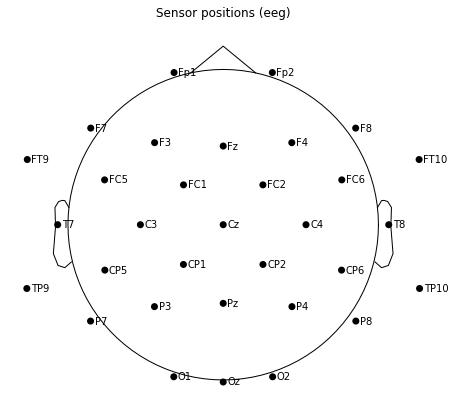

['C3', 'C4', 'CP1', 'CP2', 'CP5', 'CP6', 'Cz', 'F3', 'F4', 'F7', 'F8', 'FC1', 'FC2', 'FC5', 'FC6', 'FT10', 'FT9', 'Fp1', 'Fp2', 'Fz', 'O1', 'O2', 'Oz', 'P3', 'P4', 'P7', 'P8', 'Pz', 'T7', 'T8', 'TP10', 'TP9']


<RawGDF | ME-graz-block.gdf, 32 x 169632 (339.3 s), ~41.5 MB, data loaded>

In [53]:
## 2. load channel locations
ch_names = raw.ch_names
print(ch_names)
montage = read_custom_montage('chanloc.loc', coord_frame='head')#32ch
montage.plot(kind='topomap', show_names=True)

ch_loc = montage.ch_names
print(ch_loc)
c = dict(zip(ch_names, ch_loc)) #combine names with locations
raw.rename_channels(c)
raw.set_montage(montage)

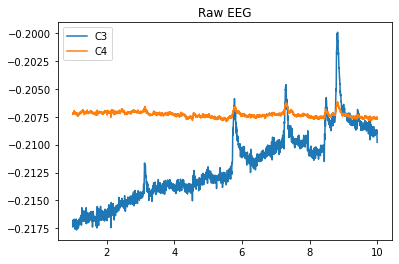

In [54]:
# plot 2-chan data sample
def plot_two_chans(ch1, ch2, title):
  channel_names = [ch1, ch2]
  two_eeg_chans = raw[channel_names, 500:5000]
  y_offset = np.array([5e-11, 0.001])  # just enough to separate the channel traces
  x = two_eeg_chans[1]
  y = two_eeg_chans[0].T + y_offset
  lines = plt.plot(x, y)
  plt.legend(lines, channel_names)
  plt.title(title)
  plt.show()

plot_two_chans('C3','C4', 'Raw EEG')

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 1651 samples (3.302 sec)



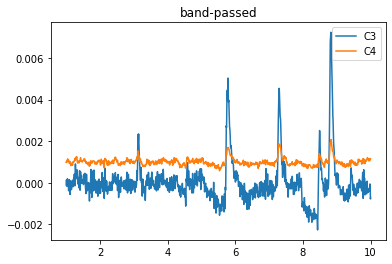

In [55]:
## 3. Apply band-pass filter
lo_freq = 1.
hi_freq = 40.

raw.filter(lo_freq, hi_freq, fir_design='firwin', skip_by_annotation='edge')

plot_two_chans('C3','C4', 'band-passed')

Adding average EEG reference projection.
1 projection items deactivated
Average reference projection was added, but has not been applied yet. Use the apply_proj method to apply it.


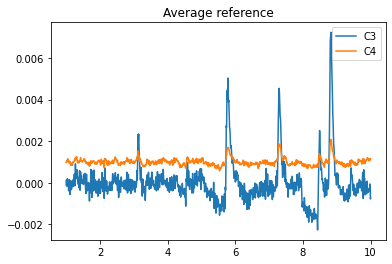

In [56]:
## 4. re-reference to average
raw.set_eeg_reference(ref_channels='average', projection=True)
plot_two_chans('C3','C4', 'Average reference')

In [57]:
## 5. epoch data

tmin, tmax = -1., 4.
event_id = dict(left=7, right=8) # from OpenVibe data
events, _ = events_from_annotations(raw, event_id='auto')

picks = pick_types(raw.info, meg=False, eeg=True, stim=False, eog=False,
                   exclude='bads')

# Read epochs (train will be done only between 1 and 4s)
epochs = Epochs(raw, events, event_id, tmin, tmax, proj=True, picks=picks, baseline=None, preload=True)
epochs_train = epochs.copy().crop(tmin=1., tmax=4.)
labels = epochs.events[:, -1] - 2

Used Annotations descriptions: ['1010', '32769', '32775', '32776', '33282', '768', '769', '770', '781', '786', '800']
24 matching events found
No baseline correction applied
Not setting metadata
Created an SSP operator (subspace dimension = 1)
1 projection items activated
Loading data for 24 events and 2501 original time points ...
0 bad epochs dropped


Fitting ICA to data using 31 channels (please be patient, this may take a while)
Inferring max_pca_components from picks
Selecting by explained variance: 10 components
Fitting ICA took 1.0s.


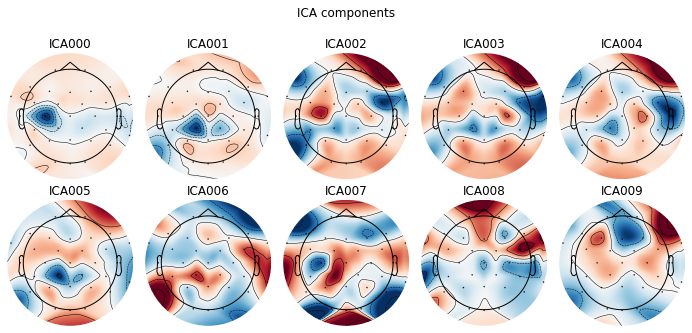

    Using multitaper spectrum estimation with 7 DPSS windows
24 matching events found
No baseline correction applied
Not setting metadata
0 projection items activated
0 bad epochs dropped
24 matching events found
No baseline correction applied
Not setting metadata
0 projection items activated
0 bad epochs dropped
24 matching events found
No baseline correction applied
Not setting metadata
0 projection items activated
0 bad epochs dropped
24 matching events found
No baseline correction applied
Not setting metadata
0 projection items activated
0 bad epochs dropped
24 matching events found
No baseline correction applied
Not setting metadata
0 projection items activated
0 bad epochs dropped


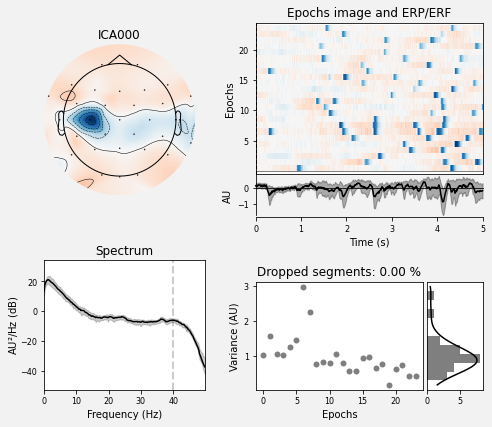

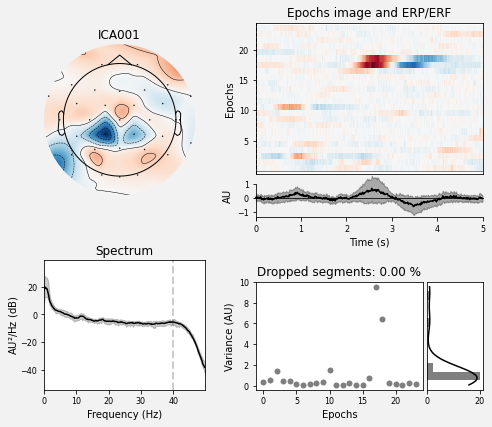

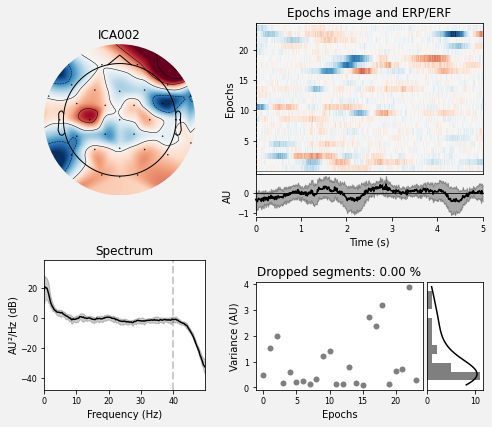

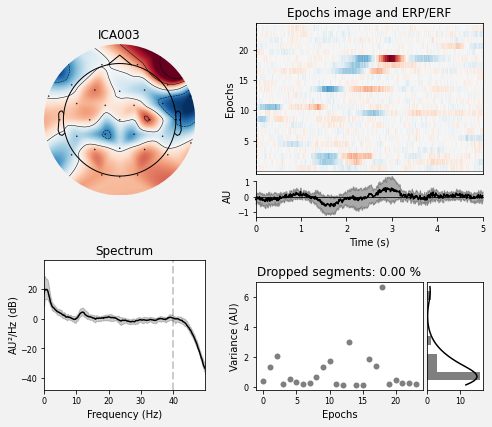

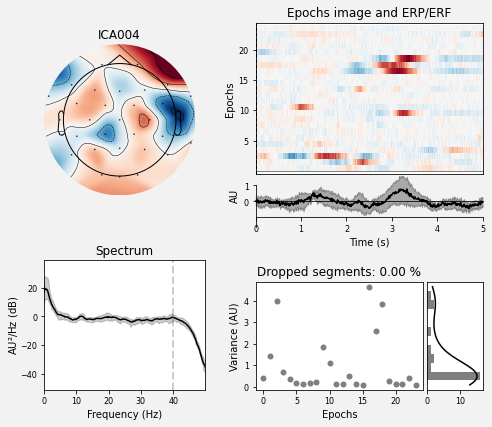

[<Figure size 504x432 with 6 Axes>,
 <Figure size 504x432 with 6 Axes>,
 <Figure size 504x432 with 6 Axes>,
 <Figure size 504x432 with 6 Axes>,
 <Figure size 504x432 with 6 Axes>]

In [58]:
## 6. Run ICA
ica = ICA(n_components=0.95, method='fastica').fit(epochs)

ica.plot_components() # plot components

ica.plot_properties(epochs) # Display component properties.

In [66]:
## 7. reject ICs
ica.exclude = [0, 1]  # indices chosen based on various plots above

# ica.apply() changes the Raw object in-place, so let's make a copy first:
reconst_raw = raw.copy()
ica.apply(reconst_raw)

#raw.plot(order=artifact_picks, n_channels=len(artifact_picks))
#reconst_raw.plot(order=artifact_picks, n_channels=len(artifact_picks))
#del reconst_raw

Transforming to ICA space (10 components)
Zeroing out 2 ICA components


<RawGDF | ME-graz-block.gdf, 32 x 169632 (339.3 s), ~41.5 MB, data loaded>

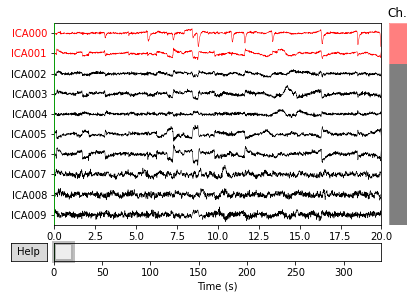

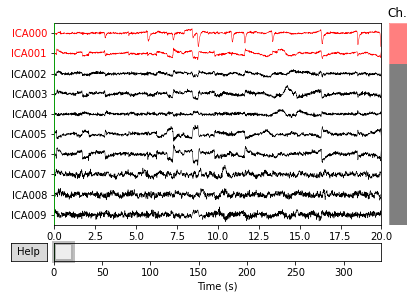

In [65]:
ica.plot_sources(raw)


24 matching events found
No baseline correction applied
Not setting metadata
Created an SSP operator (subspace dimension = 1)
1 projection items activated
Loading data for 24 events and 3001 original time points ...
0 bad epochs dropped
Not setting metadata
Applying baseline correction (mode: percent)
Using a threshold of 1.795885
stat_fun(H1): min=-6.131473 max=4.973523
Running initial clustering
Found 95 clusters
Permuting 99 times...



Computing cluster p-values
Step-down-in-jumps iteration #1 found 2 clusters to exclude from subsequent iterations
Permuting 99 times...



Computing cluster p-values
Step-down-in-jumps iteration #2 found 0 additional clusters to exclude from subsequent iterations
Done.
Using a threshold of -1.795885
stat_fun(H1): min=-6.131473 max=4.973523
Running initial clustering
Found 75 clusters
Permuting 99 times...



Computing cluster p-values
Step-down-in-jumps iteration #1 found 0 clusters to exclude from subsequent iterations
Done.
No baseline correction applied
Using a threshold of 1.795885
stat_fun(H1): min=-5.004749 max=5.157481
Running initial clustering
Found 123 clusters
Permuting 99 times...



Computing cluster p-values
Step-down-in-jumps iteration #1 found 2 clusters to exclude from subsequent iterations
Permuting 99 times...



Computing cluster p-values
Step-down-in-jumps iteration #2 found 0 additional clusters to exclude from subsequent iterations
Done.
Using a threshold of -1.795885
stat_fun(H1): min=-5.004749 max=5.157481
Running initial clustering
Found 81 clusters
Permuting 99 times...



Computing cluster p-values
Step-down-in-jumps iteration #1 found 0 clusters to exclude from subsequent iterations
Done.
No baseline correction applied
Using a threshold of 1.795885
stat_fun(H1): min=-6.812417 max=4.772517
Running initial clustering
Found 129 clusters
Permuting 99 times...



Computing cluster p-values
Step-down-in-jumps iteration #1 found 2 clusters to exclude from subsequent iterations
Permuting 99 times...



Computing cluster p-values
Step-down-in-jumps iteration #2 found 0 additional clusters to exclude from subsequent iterations
Done.
Using a threshold of -1.795885
stat_fun(H1): min=-6.812417 max=4.772517
Running initial clustering
Found 111 clusters
Permuting 99 times...



Computing cluster p-values
Step-down-in-jumps iteration #1 found 0 clusters to exclude from subsequent iterations
Done.
No baseline correction applied
Using a threshold of 1.795885
stat_fun(H1): min=-5.320947 max=4.977061
Running initial clustering
Found 101 clusters
Permuting 99 times...



Computing cluster p-values
Step-down-in-jumps iteration #1 found 1 cluster to exclude from subsequent iterations
Permuting 99 times...



Computing cluster p-values
Step-down-in-jumps iteration #2 found 0 additional clusters to exclude from subsequent iterations
Done.
Using a threshold of -1.795885
stat_fun(H1): min=-5.320947 max=4.977061
Running initial clustering
Found 110 clusters
Permuting 99 times...



Computing cluster p-values
Step-down-in-jumps iteration #1 found 0 clusters to exclude from subsequent iterations
Done.
No baseline correction applied
Using a threshold of 1.795885
stat_fun(H1): min=-6.566956 max=5.641546
Running initial clustering
Found 103 clusters
Permuting 99 times...



Computing cluster p-values
Step-down-in-jumps iteration #1 found 1 cluster to exclude from subsequent iterations
Permuting 99 times...



Computing cluster p-values
Step-down-in-jumps iteration #2 found 0 additional clusters to exclude from subsequent iterations
Done.
Using a threshold of -1.795885
stat_fun(H1): min=-6.566956 max=5.641546
Running initial clustering
Found 59 clusters
Permuting 99 times...



Computing cluster p-values
Step-down-in-jumps iteration #1 found 0 clusters to exclude from subsequent iterations
Done.
No baseline correction applied
Using a threshold of 1.795885
stat_fun(H1): min=-5.283969 max=5.516632
Running initial clustering
Found 141 clusters
Permuting 99 times...



Computing cluster p-values
Step-down-in-jumps iteration #1 found 1 cluster to exclude from subsequent iterations
Permuting 99 times...



Computing cluster p-values
Step-down-in-jumps iteration #2 found 0 additional clusters to exclude from subsequent iterations
Done.
Using a threshold of -1.795885
stat_fun(H1): min=-5.283969 max=5.516632
Running initial clustering
Found 107 clusters
Permuting 99 times...



Computing cluster p-values
Step-down-in-jumps iteration #1 found 0 clusters to exclude from subsequent iterations
Done.
No baseline correction applied


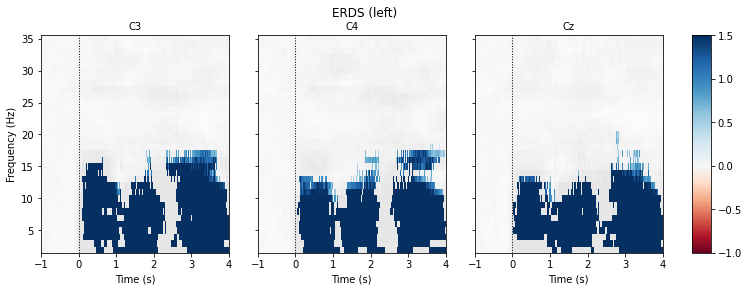

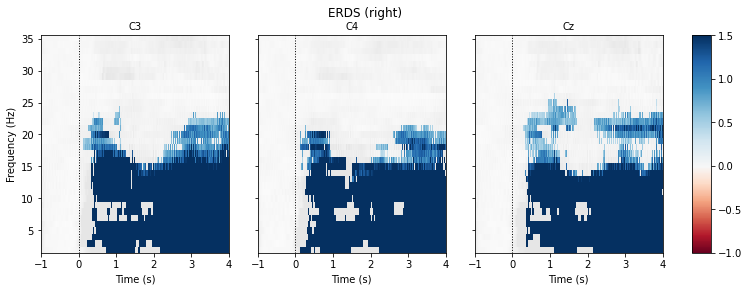

In [67]:
## 8. ERSP
from mne.time_frequency import tfr_multitaper
from mne.stats import permutation_cluster_1samp_test as pcluster_test
from mne.viz.utils import center_cmap
picks = mne.pick_channels(raw.info["ch_names"], ["C3", "Cz", "C4"])
epochs = Epochs(raw, events, event_id, tmin - 0.5, tmax + 0.5,
                    picks=picks, baseline=None, preload=True)
# compute ERDS maps ###########################################################
freqs = np.arange(2, 36, 1)  # frequencies from 2-35Hz
n_cycles = freqs  # use constant t/f resolution
vmin, vmax = -1, 1.5  # set min and max ERDS values in plot
baseline = [-1, 0]  # baseline interval (in s)
cmap = center_cmap(plt.cm.RdBu, vmin, vmax)  # zero maps to white
kwargs = dict(n_permutations=100, step_down_p=0.05, seed=1,
              buffer_size=None)  # for cluster test

# Run TF decomposition overall epochs
tfr = tfr_multitaper(epochs, freqs=freqs, n_cycles=n_cycles,
                     use_fft=True, return_itc=False, average=False,
                     decim=2)
tfr.crop(tmin, tmax)
tfr.apply_baseline(baseline, mode="percent")
for event in event_id:
    # select desired epochs for visualization
    tfr_ev = tfr[event]
    fig, axes = plt.subplots(1, 4, figsize=(12, 4),
                             gridspec_kw={"width_ratios": [10, 10, 10, 1]})
    for ch, ax in enumerate(axes[:-1]):  # for each channel
        # positive clusters
        _, c1, p1, _ = pcluster_test(tfr_ev.data[:, ch, ...], tail=1, **kwargs)
        # negative clusters
        _, c2, p2, _ = pcluster_test(tfr_ev.data[:, ch, ...], tail=-1,
                                     **kwargs)

        # note that we keep clusters with p <= 0.05 from the combined clusters
        # of two independent tests; in this example, we do not correct for
        # these two comparisons
        c = np.stack(c1 + c2, axis=2)  # combined clusters
        p = np.concatenate((p1, p2))  # combined p-values
        mask = c[..., p <= 0.05].any(axis=-1)

        # plot TFR (ERDS map with masking)
        tfr_ev.average().plot([ch], vmin=vmin, vmax=vmax, cmap=(cmap, False),
                              axes=ax, colorbar=False, show=False, mask=mask,
                              mask_style="mask")

        ax.set_title(epochs.ch_names[ch], fontsize=10)
        ax.axvline(0, linewidth=1, color="black", linestyle=":")  # event
        if not ax.is_first_col():
            ax.set_ylabel("")
            ax.set_yticklabels("")
    fig.colorbar(axes[0].images[-1], cax=axes[-1])
    fig.suptitle("ERDS ({})".format(event))
    fig.show()